#### Example of using crosswalks between census tracts of different years

This notebook used to provide example code for using the output from the script in creating geojsons with multiple years of census data for the same tract. As I'm migrating it to a dedicated script in main.py, it's now for testing different parts of that script.  

#### 1.) Download the crosswalks from the Azure container 

In [3]:
import utils

In [1]:
import tract_crosswalk
import pandas as pd
import requests
import geopandas as gpd 
import pygris
import json
import sys
import os
import us 
from logger import logger
import yaml
import census_data
import datetime as dt
import shapely
import numpy as np
import sys, getopt
import yaml
import utils

with open('config.yaml', 'r') as file: 
    config = yaml.full_load(file)

/Users/alexsocarras/tech_impact/census-tract-redistricting/venv/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
from tract_crosswalk import get_all_tract_geoms_year, get_tract_crosswalks
from census_data import load_raw_census_data, _transform_raw_data_long, _widen_df, _extract_2020_data, _collapse_df, join_crosswalk, apply_crosswalk, rejoin_2020, join_geoms, bin_variables
from logger import logger

## Download/load crosswalk and pygris geoms 
logger.info(f'Obtaining tract crosswalks (tract_crosswalk.py)')
get_tract_crosswalks() 

logger.info(f'Obtaining simplified geometries from pygris')
py_geoms = get_all_tract_geoms_year(year=2020, erase_water=False, simplify_tolerance=.001)
# get_tract_crosswalks uses raw (unsimplified) geometries to calculate overlaps -- these are for our final output here

## Download (or load cached) raw census data
df = load_raw_census_data()

## Transform raw data (long format)
df_long = _transform_raw_data_long(df)

## Widen data 
wide_df = _widen_df(df_long)

## Apply binning (if parameters set)
binned_df = bin_variables(wide_df)
    
# ## Separate 2020 data from other years
# df_2020 = _extract_2020_data(wide_df)

# ## Collapse pre-2020 data 
# df = _collapse_df(wide_df)

# ## Join and apply the crosswalk column to the pre-2020 data
# df = join_crosswalk(df)
# df = apply_crosswalk(df)

# ## Re-Join the 2020 data to crosswalked pre-2020 data
# df = rejoin_2020(df, df_2020)

# ## Join the geometries 
# df = join_geoms(df, py_geoms)

# df

2023-12-28 12:16:29,836 - logger - INFO - Obtaining tract crosswalks (tract_crosswalk.py)
2023-12-28 12:16:29,844 - logger - INFO - (OVERWRITE_AZURE=False, OVERWRITE_LOCAL=False)
2023-12-28 12:16:30,039 - logger - INFO - Checking if crosswalks exist:
{'file': 'convert-ctracts_pct-area_2010-to-2020.json', 'local': True, 'azure': True}
{'file': 'convert-ctracts_pct-area_2020-to-2010.json', 'local': True, 'azure': True}
2023-12-28 12:16:30,039 - logger - INFO - Local crosswalks exist and OVERWRITE_LOCAL=False. Aborting script.
2023-12-28 12:16:30,040 - logger - INFO - Obtaining simplified geometries from pygris
2023-12-28 12:16:30,040 - logger - INFO - Using geometry path: data/pygris_2020_tract-geoms_allStates+DC+PR__tol-0.001.json
2023-12-28 12:16:30,040 - logger - INFO - Loading cached geoms (data/pygris_2020_tract-geoms_allStates+DC+PR__tol-0.001.json)
2023-12-28 12:16:45,083 - logger - INFO - Found raw census data data/raw/B19013_001E_allStates+DC_2010-2020.csv


In [2]:
binned_df

,,,,,,,,B19013_001E-2010,B19013_001E-2011,B19013_001E-2012,B19013_001E-2013,B19013_001E-2014,B19013_001E-2015,B19013_001E-2016,B19013_001E-2017,B19013_001E-2018,B19013_001E-2019,B19013_001E-2020
GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,,,,,,,,,,,
01001020100,01,Alabama,AL,001,Autauga,020100,201,70222.0,58846.0,56500.0,63030.0,60000.0,61838.0,66000.0,67826.0,58625.0,60208.0,60388.0
01001020200,01,Alabama,AL,001,Autauga,020200,202,41091.0,42019.0,41250.0,44019.0,42971.0,32303.0,41107.0,41287.0,43531.0,43958.0,49144.0
01001020300,01,Alabama,AL,001,Autauga,020300,203,44031.0,43145.0,43088.0,43201.0,43717.0,44922.0,51250.0,46806.0,51875.0,55345.0,62423.0
01001020400,01,Alabama,AL,001,Autauga,020400,204,56627.0,58419.0,54503.0,54730.0,55814.0,54329.0,52704.0,55895.0,54050.0,59663.0,64310.0
01001020500,01,Alabama,AL,001,Autauga,020500,205,68317.0,68301.0,65027.0,65132.0,57349.0,51965.0,52463.0,68143.0,72417.0,66108.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56043000200,56,Wyoming,WY,043,Washakie,000200,2,53686.0,60560.0,52804.0,55938.0,51799.0,54545.0,51024.0,59706.0,54936.0,55859.0,55268.0
56043000301,56,Wyoming,WY,043,Washakie,000301,3.01,40304.0,40086.0,37700.0,34619.0,35691.0,34643.0,38221.0,41496.0,50428.0,46500.0,52074.0
56043000302,56,Wyoming,WY,043,Washakie,000302,3.02,56086.0,61298.0,58026.0,58534.0,49844.0,55192.0,52581.0,52214.0,56141.0,58634.0,65543.0


In [69]:
a = wide_df.reset_index()

dataframes = []
for state_name in a['state_name'].unique():
    state_df = a[a['state_name'] == state_name]
    dataframes.append(state_df)
b = pd.concat(dataframes, ignore_index=True)

a.equals(b)


True

In [67]:
display(b,a)

,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,B19013_001E-2010,B19013_001E-2011,B19013_001E-2012,B19013_001E-2013,B19013_001E-2014,B19013_001E-2015,B19013_001E-2016,B19013_001E-2017,B19013_001E-2018,B19013_001E-2019,B19013_001E-2020
0,01001020100,01,Alabama,AL,001,Autauga,020100,201,70222.0,58846.0,56500.0,63030.0,60000.0,61838.0,66000.0,67826.0,58625.0,60208.0,60388.0
1,01001020200,01,Alabama,AL,001,Autauga,020200,202,41091.0,42019.0,41250.0,44019.0,42971.0,32303.0,41107.0,41287.0,43531.0,43958.0,49144.0
2,01001020300,01,Alabama,AL,001,Autauga,020300,203,44031.0,43145.0,43088.0,43201.0,43717.0,44922.0,51250.0,46806.0,51875.0,55345.0,62423.0
3,01001020400,01,Alabama,AL,001,Autauga,020400,204,56627.0,58419.0,54503.0,54730.0,55814.0,54329.0,52704.0,55895.0,54050.0,59663.0,64310.0
4,01001020500,01,Alabama,AL,001,Autauga,020500,205,68317.0,68301.0,65027.0,65132.0,57349.0,51965.0,52463.0,68143.0,72417.0,66108.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95908,11001011000,11,District of Columbia,DC,001,District of Columbia,011000,110,79297.0,74500.0,90637.0,82275.0,87906.0,82548.0,81667.0,75529.0,84375.0,95370.0,NaN
95909,11001011001,11,District of Columbia,DC,001,District of Columbia,011001,110.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115114.0
95910,11001011002,11,District of Columbia,DC,001,District of Columbia,011002,110.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105182.0
95911,11001011100,11,District of Columbia,DC,001,District of Columbia,011100,111,55353.0,60268.0,58824.0,55108.0,58833.0,68750.0,59716.0,75781.0,79628.0,80466.0,63625.0


,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,B19013_001E-2010,B19013_001E-2011,B19013_001E-2012,B19013_001E-2013,B19013_001E-2014,B19013_001E-2015,B19013_001E-2016,B19013_001E-2017,B19013_001E-2018,B19013_001E-2019,B19013_001E-2020
0,01001020100,01,Alabama,AL,001,Autauga,020100,201,70222.0,58846.0,56500.0,63030.0,60000.0,61838.0,66000.0,67826.0,58625.0,60208.0,60388.0
1,01001020200,01,Alabama,AL,001,Autauga,020200,202,41091.0,42019.0,41250.0,44019.0,42971.0,32303.0,41107.0,41287.0,43531.0,43958.0,49144.0
2,01001020300,01,Alabama,AL,001,Autauga,020300,203,44031.0,43145.0,43088.0,43201.0,43717.0,44922.0,51250.0,46806.0,51875.0,55345.0,62423.0
3,01001020400,01,Alabama,AL,001,Autauga,020400,204,56627.0,58419.0,54503.0,54730.0,55814.0,54329.0,52704.0,55895.0,54050.0,59663.0,64310.0
4,01001020500,01,Alabama,AL,001,Autauga,020500,205,68317.0,68301.0,65027.0,65132.0,57349.0,51965.0,52463.0,68143.0,72417.0,66108.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95908,56043000200,56,Wyoming,WY,043,Washakie,000200,2,53686.0,60560.0,52804.0,55938.0,51799.0,54545.0,51024.0,59706.0,54936.0,55859.0,55268.0
95909,56043000301,56,Wyoming,WY,043,Washakie,000301,3.01,40304.0,40086.0,37700.0,34619.0,35691.0,34643.0,38221.0,41496.0,50428.0,46500.0,52074.0
95910,56043000302,56,Wyoming,WY,043,Washakie,000302,3.02,56086.0,61298.0,58026.0,58534.0,49844.0,55192.0,52581.0,52214.0,56141.0,58634.0,65543.0
95911,56045951100,56,Wyoming,WY,045,Weston,951100,9511,52440.0,64103.0,64412.0,66653.0,66515.0,69222.0,69048.0,62435.0,50000.0,52763.0,51694.0


In [71]:
len(a.columns)

19

In [64]:
(pd.merge(a, b, how='inner')).equals(a)

True

ValueError: If using all scalar values, you must pass an index

In [33]:
 == len(a.columns)

True

In [16]:
a,b ="B19013_001E-2011".split('-')	
a

'B19013_001E'

In [7]:
df_long

,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,year,B19013_001E
0,01001020100,01,Alabama,AL,001,Autauga,020100,201,2010,70222.0
1,01001020200,01,Alabama,AL,001,Autauga,020200,202,2010,41091.0
2,01001020300,01,Alabama,AL,001,Autauga,020300,203,2010,44031.0
3,01001020400,01,Alabama,AL,001,Autauga,020400,204,2010,56627.0
4,01001020500,01,Alabama,AL,001,Autauga,020500,205,2010,68317.0
...,...,...,...,...,...,...,...,...,...,...
201,11001007504,11,District of Columbia,DC,001,District of Columbia,007504,75.04,2020,16844.0
202,11001007601,11,District of Columbia,DC,001,District of Columbia,007601,76.01,2020,40330.0
203,11001007603,11,District of Columbia,DC,001,District of Columbia,007603,76.03,2020,60833.0
204,11001007604,11,District of Columbia,DC,001,District of Columbia,007604,76.04,2020,72946.0


In [4]:
wide_df

,,,,,,,,B19013_001E-2010,B19013_001E-2011,B19013_001E-2012,B19013_001E-2013,B19013_001E-2014,B19013_001E-2015,B19013_001E-2016,B19013_001E-2017,B19013_001E-2018,B19013_001E-2019
GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,,,,,,,,,,
01001020100,01,Alabama,AL,001,Autauga,020100,201,70222.0,58846.0,56500.0,63030.0,60000.0,61838.0,66000.0,67826.0,58625.0,60208.0
01001020200,01,Alabama,AL,001,Autauga,020200,202,41091.0,42019.0,41250.0,44019.0,42971.0,32303.0,41107.0,41287.0,43531.0,43958.0
01001020300,01,Alabama,AL,001,Autauga,020300,203,44031.0,43145.0,43088.0,43201.0,43717.0,44922.0,51250.0,46806.0,51875.0,55345.0
01001020400,01,Alabama,AL,001,Autauga,020400,204,56627.0,58419.0,54503.0,54730.0,55814.0,54329.0,52704.0,55895.0,54050.0,59663.0
01001020500,01,Alabama,AL,001,Autauga,020500,205,68317.0,68301.0,65027.0,65132.0,57349.0,51965.0,52463.0,68143.0,72417.0,66108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56043000200,56,Wyoming,WY,043,Washakie,000200,2,53686.0,60560.0,52804.0,55938.0,51799.0,54545.0,51024.0,59706.0,54936.0,55859.0
56043000301,56,Wyoming,WY,043,Washakie,000301,3.01,40304.0,40086.0,37700.0,34619.0,35691.0,34643.0,38221.0,41496.0,50428.0,46500.0
56043000302,56,Wyoming,WY,043,Washakie,000302,3.02,56086.0,61298.0,58026.0,58534.0,49844.0,55192.0,52581.0,52214.0,56141.0,58634.0


In [13]:
py_geoms2 = py_geoms.rename({'STATEFP': 'state_fips',
                     'COUNTYFP': 'county_fips', 
                     'TRACTCE': 'tract_fips', 
                     'NAME': 'tract_dec'}, axis=1)

shared_columns = ['state_fips', 'county_fips', 'tract_fips', 'tract_dec']
# Keep only needed columns (drop 'NAMELSAD', 'MTFCC', 'FUNCSTAT')
py_geoms2 = py_geoms2[shared_columns + ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']]
# Keep only states from config.yaml
states_fips_to_keep = [s['fips'] for s in utils.load_state_list(config['states'])]
py_geoms2 = py_geoms2[py_geoms2['state_fips'].isin(states_fips_to_keep)]
py_geoms2

,state_fips,county_fips,tract_fips,tract_dec,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID_TRACT_20,,,,,,,,,
01045020801,01,045,020801,208.01,19261326,0,+31.3971437,-085.6615959,"POLYGON ((-85.70064 31.38509, -85.69648 31.388..."
01017954200,01,017,954200,9542,62998696,34641,+32.8341436,-085.2678516,"POLYGON ((-85.31549 32.80580, -85.31003 32.813..."
01017953800,01,017,953800,9538,515692207,11516898,+33.0302580,-085.3867880,"POLYGON ((-85.59345 33.00012, -85.59318 33.107..."
01017954300,01,017,954300,9543,132642536,178276,+32.7766468,-085.2734917,"POLYGON ((-85.38077 32.78301, -85.37879 32.782..."
01017954700,01,017,954700,9547,38036820,264376,+32.7702191,-085.1744682,"POLYGON ((-85.22897 32.74543, -85.22332 32.754..."
...,...,...,...,...,...,...,...,...,...
11001009801,11,001,009801,98.01,431384,7884,+38.8328939,-076.9963306,"POLYGON ((-77.00386 38.83099, -77.00228 38.833..."
11001002801,11,001,002801,28.01,171910,0,+38.9349477,-077.0345166,"POLYGON ((-77.03646 38.93412, -77.03645 38.937..."
11001002802,11,001,002802,28.02,229696,0,+38.9294344,-077.0346327,"POLYGON ((-77.03671 38.92712, -77.03646 38.933..."


In [48]:
2df.isna().sum()

GEOID          0
state_fips     0
state_name     0
state_usps     0
county_fips    0
county_name    0
tract_fips     0
tract_dec      0
B19013_001E    0
dtype: int64

In [49]:
py_geoms.isna().sum()

state_fips     0
county_fips    0
tract_fips     0
tract_dec      0
ALAND          0
AWATER         0
INTPTLAT       0
INTPTLON       0
geometry       0
dtype: int64

In [50]:
# Join
df_geoms = df.merge(py_geoms, how='right', on=shared_columns)

In [52]:
df_geoms.isna().sum()

GEOID          601
state_fips       0
state_name     601
state_usps     601
county_fips      0
county_name    601
tract_fips       0
tract_dec        0
B19013_001E    601
ALAND            0
AWATER           0
INTPTLAT         0
INTPTLON         0
geometry         0
dtype: int64

In [44]:
df_geoms.isna().sum()

GEOID          601
state_fips       0
state_name     601
state_usps     601
county_fips      0
county_name    601
tract_fips       0
tract_dec        0
B19013_001E    601
ALAND            0
AWATER           0
INTPTLAT         0
INTPTLON         0
geometry         0
dtype: int64

In [39]:
df_geoms[df_geoms['GEOID'].isna()]

,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,B19013_001E,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
446,NaN,01,NaN,NaN,003,NaN,990000,9900,NaN,0,815342622,+30.3288009,-087.8829736,"POLYGON ((-88.03693 30.19937, -88.03711 30.222..."
620,NaN,01,NaN,NaN,097,NaN,990000,9900,NaN,0,780537710,+30.2698833,-088.2923593,"POLYGON ((-88.39379 30.34566, -88.36950 30.360..."
807,NaN,01,NaN,NaN,097,NaN,980000,9800,NaN,1895047,0,+30.6951462,-088.1824733,"POLYGON ((-88.19230 30.69524, -88.19097 30.695..."
1357,NaN,01,NaN,NaN,015,NaN,981903,9819.03,NaN,36029495,1072,+33.7072288,-085.7502859,"POLYGON ((-85.78501 33.66553, -85.77850 33.667..."
1624,NaN,04,NaN,NaN,027,NaN,980003,9800.03,NaN,1843805607,139619,+32.2428436,-113.5327647,"POLYGON ((-113.96145 32.24504, -113.96124 32.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83547,NaN,55,NaN,NaN,101,NaN,990000,9900,NaN,0,1150055845,+42.7540747,-087.4146759,"POLYGON ((-87.81595 42.84258, -87.06942 42.842..."
83551,NaN,55,NaN,NaN,003,NaN,990000,9900,NaN,0,2113546457,+47.1291288,-090.1846558,"POLYGON ((-90.86732 47.21096, -90.65466 47.309..."
83667,NaN,55,NaN,NaN,029,NaN,990000,9900,NaN,0,3235661755,+45.0162911,-086.8164838,"POLYGON ((-87.37033 44.67558, -87.34893 44.702..."
83715,NaN,55,NaN,NaN,061,NaN,990000,9900,NaN,0,1896474482,+44.5008790,-087.1604375,"POLYGON ((-87.53727 44.33179, -87.53098 44.340..."


In [53]:
py_geoms2 = py_geoms.rename({'STATEFP': 'state_fips',
                    'COUNTYFP': 'county_fips', 
                    'TRACTCE': 'tract_fips', 
                    'NAME': 'tract_dec'}, axis=1)
shared_columns = ['state_fips', 'county_fips', 'tract_fips', 'tract_dec']
# Keep only needed columns (drop 'NAMELSAD', 'MTFCC', 'FUNCSTAT')
py_geoms2 = py_geoms2[shared_columns + ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']]

df_geoms = df.merge(py_geoms2, how='right', on=shared_columns)

df_geoms.head(1).T

,0
GEOID,01045020801
state_fips,01
state_name,Alabama
state_usps,AL
county_fips,045
county_name,Dale
tract_fips,020801
tract_dec,208.01
B19013_001E,"{'2010': 42076.8, '2011': 43562.01, '2012': 43..."
ALAND,19261326


In [54]:
py_geoms2.head(1).T

GEOID_TRACT_20,01045020801
state_fips,01
county_fips,045
tract_fips,020801
tract_dec,208.01
ALAND,19261326
AWATER,0
INTPTLAT,+31.3971437
INTPTLON,-085.6615959
geometry,"POLYGON ((-85.700637 31.385095, -85.696477 31...."


In [21]:
import utils 
utils.load_state_list(config['states'])


[{'name': 'Alabama', 'fips': '01', 'usps': 'AL'},
 {'name': 'Alaska', 'fips': '02', 'usps': 'AK'},
 {'name': 'Arizona', 'fips': '04', 'usps': 'AZ'},
 {'name': 'Arkansas', 'fips': '05', 'usps': 'AR'},
 {'name': 'California', 'fips': '06', 'usps': 'CA'},
 {'name': 'Colorado', 'fips': '08', 'usps': 'CO'},
 {'name': 'Connecticut', 'fips': '09', 'usps': 'CT'},
 {'name': 'Delaware', 'fips': '10', 'usps': 'DE'},
 {'name': 'Florida', 'fips': '12', 'usps': 'FL'},
 {'name': 'Georgia', 'fips': '13', 'usps': 'GA'},
 {'name': 'Hawaii', 'fips': '15', 'usps': 'HI'},
 {'name': 'Idaho', 'fips': '16', 'usps': 'ID'},
 {'name': 'Illinois', 'fips': '17', 'usps': 'IL'},
 {'name': 'Indiana', 'fips': '18', 'usps': 'IN'},
 {'name': 'Iowa', 'fips': '19', 'usps': 'IA'},
 {'name': 'Kansas', 'fips': '20', 'usps': 'KS'},
 {'name': 'Kentucky', 'fips': '21', 'usps': 'KY'},
 {'name': 'Louisiana', 'fips': '22', 'usps': 'LA'},
 {'name': 'Maine', 'fips': '23', 'usps': 'ME'},
 {'name': 'Maryland', 'fips': '24', 'usps': 'M

In [3]:

## Join the geometries 
df_geoms = df.merge(py_geoms, how='right', left_on='GEOID', right_index=True)
# df_geoms = df_geoms[~(df_geoms['GEOID'].isna()) & ~(df_geoms['geometry'].isna())] # TO-DO: Handle/Monitor/Track NaNs

In [4]:
df_geoms

,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,B19013_001E,STATEFP,...,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
276.0,01045020801,01,Alabama,AL,045,Dale,020801,208.01,"{'2010': 42076.8, '2011': 43562.01, '2012': 43...",01,...,020801,208.01,Census Tract 208.01,G5020,S,19261326,0,+31.3971437,-085.6615959,"POLYGON ((-85.70064 31.38509, -85.69648 31.388..."
147.0,01017954200,01,Alabama,AL,017,Chambers,954200,9542,"{'2010': 34587.38, '2011': 38507.45, '2012': 3...",01,...,954200,9542,Census Tract 9542,G5020,S,62998696,34641,+32.8341436,-085.2678516,"POLYGON ((-85.31549 32.80580, -85.31003 32.813..."
143.0,01017953800,01,Alabama,AL,017,Chambers,953800,9538,"{'2010': 32068.0, '2011': 34271.0, '2012': 332...",01,...,953800,9538,Census Tract 9538,G5020,S,515692207,11516898,+33.0302580,-085.3867880,"POLYGON ((-85.59345 33.00012, -85.59318 33.107..."
148.0,01017954300,01,Alabama,AL,017,Chambers,954300,9543,"{'2010': 28136.0, '2011': 30920.0, '2012': 304...",01,...,954300,9543,Census Tract 9543,G5020,S,132642536,178276,+32.7766468,-085.2734917,"POLYGON ((-85.38077 32.78301, -85.37879 32.782..."
151.0,01017954700,01,Alabama,AL,017,Chambers,954700,9547,"{'2010': 31368.0, '2011': 34071.0, '2012': 334...",01,...,954700,9547,Census Tract 9547,G5020,S,38036820,264376,+32.7702191,-085.1744682,"POLYGON ((-85.22897 32.74543, -85.22332 32.754..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,72119130300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,...,130300,1303,Census Tract 1303,G5020,S,8150827,110315,+18.3989008,-065.8358049,"POLYGON ((-65.85254 18.40170, -65.84382 18.405..."
NaN,72119130500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,...,130500,1305,Census Tract 1305,G5020,S,1215550,0,+18.3759303,-065.8453190,"POLYGON ((-65.85240 18.37359, -65.85014 18.380..."
NaN,72087110102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,...,110102,1101.02,Census Tract 1101.02,G5020,S,2518426,27500,+18.4151874,-065.8422860,"POLYGON ((-65.85261 18.40230, -65.84763 18.413..."
NaN,72087110200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,...,110200,1102,Census Tract 1102,G5020,S,1045973,791595,+18.4298876,-065.8446315,"POLYGON ((-65.84922 18.43887, -65.83888 18.438..."


In [5]:
py_geoms

,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID_TRACT_20,,,,,,,,,,,,
01045020801,01,045,020801,208.01,Census Tract 208.01,G5020,S,19261326,0,+31.3971437,-085.6615959,"POLYGON ((-85.70064 31.38509, -85.69648 31.388..."
01017954200,01,017,954200,9542,Census Tract 9542,G5020,S,62998696,34641,+32.8341436,-085.2678516,"POLYGON ((-85.31549 32.80580, -85.31003 32.813..."
01017953800,01,017,953800,9538,Census Tract 9538,G5020,S,515692207,11516898,+33.0302580,-085.3867880,"POLYGON ((-85.59345 33.00012, -85.59318 33.107..."
01017954300,01,017,954300,9543,Census Tract 9543,G5020,S,132642536,178276,+32.7766468,-085.2734917,"POLYGON ((-85.38077 32.78301, -85.37879 32.782..."
01017954700,01,017,954700,9547,Census Tract 9547,G5020,S,38036820,264376,+32.7702191,-085.1744682,"POLYGON ((-85.22897 32.74543, -85.22332 32.754..."
...,...,...,...,...,...,...,...,...,...,...,...,...
72119130300,72,119,130300,1303,Census Tract 1303,G5020,S,8150827,110315,+18.3989008,-065.8358049,"POLYGON ((-65.85254 18.40170, -65.84382 18.405..."
72119130500,72,119,130500,1305,Census Tract 1305,G5020,S,1215550,0,+18.3759303,-065.8453190,"POLYGON ((-65.85240 18.37359, -65.85014 18.380..."
72087110102,72,087,110102,1101.02,Census Tract 1101.02,G5020,S,2518426,27500,+18.4151874,-065.8422860,"POLYGON ((-65.85261 18.40230, -65.84763 18.413..."


In [9]:
df_geoms

,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,B19013_001E,geometry
276.0,01045020801,01,Alabama,AL,045,Dale,020801,208.01,"{'2010': 42076.8, '2011': 43562.01, '2012': 43...","POLYGON ((-85.70064 31.38509, -85.69648 31.388..."
147.0,01017954200,01,Alabama,AL,017,Chambers,954200,9542,"{'2010': 34587.38, '2011': 38507.45, '2012': 3...","POLYGON ((-85.31549 32.80580, -85.31003 32.813..."
143.0,01017953800,01,Alabama,AL,017,Chambers,953800,9538,"{'2010': 32068.0, '2011': 34271.0, '2012': 332...","POLYGON ((-85.59345 33.00012, -85.59318 33.107..."
148.0,01017954300,01,Alabama,AL,017,Chambers,954300,9543,"{'2010': 28136.0, '2011': 30920.0, '2012': 304...","POLYGON ((-85.38077 32.78301, -85.37879 32.782..."
151.0,01017954700,01,Alabama,AL,017,Chambers,954700,9547,"{'2010': 31368.0, '2011': 34071.0, '2012': 334...","POLYGON ((-85.22897 32.74543, -85.22332 32.754..."
...,...,...,...,...,...,...,...,...,...,...
NaN,72119130300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-65.85254 18.40170, -65.84382 18.405..."
NaN,72119130500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-65.85240 18.37359, -65.85014 18.380..."
NaN,72087110102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-65.85261 18.40230, -65.84763 18.413..."
NaN,72087110200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-65.84922 18.43887, -65.83888 18.438..."


In [6]:
py_geoms

,geometry
GEOID_TRACT_20,
01045020801,"POLYGON ((-85.70064 31.38509, -85.69648 31.388..."
01017954200,"POLYGON ((-85.31549 32.80580, -85.31003 32.813..."
01017953800,"POLYGON ((-85.59345 33.00012, -85.59318 33.107..."
01017954300,"POLYGON ((-85.38077 32.78301, -85.37879 32.782..."
01017954700,"POLYGON ((-85.22897 32.74543, -85.22332 32.754..."
...,...
72119130300,"POLYGON ((-65.85254 18.40170, -65.84382 18.405..."
72119130500,"POLYGON ((-65.85240 18.37359, -65.85014 18.380..."
72087110102,"POLYGON ((-65.85261 18.40230, -65.84763 18.413..."


In [35]:
gdf_geoms = gpd.GeoDataFrame(df_geoms)
gdf_geoms.fillna(value='NaN', inplace=True)
for cvar in config['census_vars']: 
    gdf_geoms[cvar] = df_geoms[cvar].apply(lambda x: utils.replace_dict_nans(x))

,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,B19013_001E,geometry


In [36]:
gdf_geoms.to_file('test_nan_.json')

In [37]:
gdf_geoms.isna().sum()

GEOID          0
state_fips     0
state_name     0
state_usps     0
county_fips    0
county_name    0
tract_fips     0
tract_dec      0
B19013_001E    0
geometry       0
dtype: int64

In [41]:
df

,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,B19013_001E
0,01001020100,01,Alabama,AL,001,Autauga,020100,201,"{'2010': 70151.78, '2011': 58787.15, '2012': 5..."
1,01001020803,01,Alabama,AL,001,Autauga,020803,208.03,"{'2010': 58420.0, '2011': 59149.0, '2012': 600..."
2,01001020200,01,Alabama,AL,001,Autauga,020200,202,"{'2010': 41091.0, '2011': 42019.0, '2012': 412..."
3,01001020300,01,Alabama,AL,001,Autauga,020300,203,"{'2010': 44031.0, '2011': 43145.0, '2012': 430..."
4,01001020400,01,Alabama,AL,001,Autauga,020400,204,"{'2010': 56627.0, '2011': 58419.0, '2012': 545..."
...,...,...,...,...,...,...,...,...,...
83844,56043000200,56,Wyoming,WY,043,Washakie,000200,2,"{'2010': 53686.0, '2011': 60560.0, '2012': 528..."
83845,56043000302,56,Wyoming,WY,043,Washakie,000302,3.02,"{'2010': 56066.8, '2011': 61292.1, '2012': 579..."
83846,56043000301,56,Wyoming,WY,043,Washakie,000301,3.01,"{'2010': 40304.0, '2011': 40086.0, '2012': 377..."
83847,56045951100,56,Wyoming,WY,045,Weston,951100,9511,"{'2010': 52440.0, '2011': 64103.0, '2012': 644..."


In [13]:
print([col for col in py_geoms.columns if col not in ('NAMELSAD', 'MTFCC', 'FUNCSTAT')])

['STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']


In [11]:
df_geoms.head()

,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,B19013_001E,STATEFP,...,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
276.0,01045020801,01,Alabama,AL,045,Dale,020801,208.01,"{'2010': 42076.8, '2011': 43562.01, '2012': 43...",01,...,020801,208.01,Census Tract 208.01,G5020,S,19261326,0,+31.3971437,-085.6615959,"POLYGON ((-85.70064 31.38509, -85.69648 31.388..."
147.0,01017954200,01,Alabama,AL,017,Chambers,954200,9542,"{'2010': 34587.38, '2011': 38507.45, '2012': 3...",01,...,954200,9542,Census Tract 9542,G5020,S,62998696,34641,+32.8341436,-085.2678516,"POLYGON ((-85.31549 32.80580, -85.31003 32.813..."
143.0,01017953800,01,Alabama,AL,017,Chambers,953800,9538,"{'2010': 32068.0, '2011': 34271.0, '2012': 332...",01,...,953800,9538,Census Tract 9538,G5020,S,515692207,11516898,+33.0302580,-085.3867880,"POLYGON ((-85.59345 33.00012, -85.59318 33.107..."
148.0,01017954300,01,Alabama,AL,017,Chambers,954300,9543,"{'2010': 28136.0, '2011': 30920.0, '2012': 304...",01,...,954300,9543,Census Tract 9543,G5020,S,132642536,178276,+32.7766468,-085.2734917,"POLYGON ((-85.38077 32.78301, -85.37879 32.782..."
151.0,01017954700,01,Alabama,AL,017,Chambers,954700,9547,"{'2010': 31368.0, '2011': 34071.0, '2012': 334...",01,...,954700,9547,Census Tract 9547,G5020,S,38036820,264376,+32.7702191,-085.1744682,"POLYGON ((-85.22897 32.74543, -85.22332 32.754..."


In [39]:
gdf_geoms

,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,B19013_001E,geometry
0,01001020100,01,Alabama,AL,001,Autauga,020100,201,"{'2010': 70151.78, '2011': 58787.15, '2012': 5...","POLYGON ((-86.51038 32.47225, -86.50400 32.477..."
1,01001020803,01,Alabama,AL,001,Autauga,020803,208.03,"{'2010': 58420.0, '2011': 59149.0, '2012': 600...","POLYGON ((-86.64579 32.55438, -86.64300 32.559..."
2,01001020200,01,Alabama,AL,001,Autauga,020200,202,"{'2010': 41091.0, '2011': 42019.0, '2012': 412...","POLYGON ((-86.48127 32.47744, -86.47887 32.489..."
3,01001020300,01,Alabama,AL,001,Autauga,020300,203,"{'2010': 44031.0, '2011': 43145.0, '2012': 430...","POLYGON ((-86.47087 32.47573, -86.46950 32.485..."
4,01001020400,01,Alabama,AL,001,Autauga,020400,204,"{'2010': 56627.0, '2011': 58419.0, '2012': 545...","POLYGON ((-86.45394 32.49318, -86.44742 32.493..."
...,...,...,...,...,...,...,...,...,...,...
83844,56043000200,56,Wyoming,WY,043,Washakie,000200,2,"{'2010': 53686.0, '2011': 60560.0, '2012': 528...","POLYGON ((-108.55079 44.12770, -108.55056 44.1..."
83845,56043000302,56,Wyoming,WY,043,Washakie,000302,3.02,"{'2010': 56066.8, '2011': 61292.1, '2012': 579...","POLYGON ((-107.99564 43.97932, -107.98937 43.9..."
83846,56043000301,56,Wyoming,WY,043,Washakie,000301,3.01,"{'2010': 40304.0, '2011': 40086.0, '2012': 377...","POLYGON ((-107.96833 44.00860, -107.95875 44.0..."
83847,56045951100,56,Wyoming,WY,045,Weston,951100,9511,"{'2010': 52440.0, '2011': 64103.0, '2012': 644...","POLYGON ((-105.08177 43.59211, -105.07878 43.8..."


In [3]:

## Re-Join the 2020 data to crosswalked pre-2020 data
rejoin_df = rejoin_2020(apply_df, df_2020)

rejoin_df

{'2010': 70151.78,
 '2011': 58787.15,
 '2012': 56443.5,
 '2013': 62966.97,
 '2014': 59940.0,
 '2015': 61776.16,
 '2016': 65934.0,
 '2017': 67758.17,
 '2018': 58566.38,
 '2019': 60147.79,
 '2020': 60388.0}

In [2]:
# logger.info(f'Obtaining geometries')
py_geoms = get_all_tract_geoms_year(year=2020, erase_water=False, simplify_tolerance=.001)
py_geoms

2023-12-22 14:03:35,518 - logger - INFO - Using geometry path: data/pygris_2020_tract-geoms_allStates+DC+PR__tol-0.001.json
2023-12-22 14:03:35,519 - logger - INFO - Loading cached geoms (data/pygris_2020_tract-geoms_allStates+DC+PR__tol-0.001.json)


,geometry
GEOID_TRACT_20,
01045020801,"POLYGON ((-85.70064 31.38509, -85.69648 31.388..."
01017954200,"POLYGON ((-85.31549 32.80580, -85.31003 32.813..."
01017953800,"POLYGON ((-85.59345 33.00012, -85.59318 33.107..."
01017954300,"POLYGON ((-85.38077 32.78301, -85.37879 32.782..."
01017954700,"POLYGON ((-85.22897 32.74543, -85.22332 32.754..."
...,...
72119130300,"POLYGON ((-65.85254 18.40170, -65.84382 18.405..."
72119130500,"POLYGON ((-65.85240 18.37359, -65.85014 18.380..."
72087110102,"POLYGON ((-65.85261 18.40230, -65.84763 18.413..."


In [23]:
df_geoms = rejoin_df.merge(py_geoms, how='left', left_on='GEOID', right_index=True)
# df_geoms = df_geoms[~(df_geoms['GEOID'].isna()) & ~(df_geoms['geometry'].isna())] # TO-DO: Handle/Monitor/Track NaNs

df_geoms

,GEOID,state_fips,state_name,state_usps,county_fips,county_name,tract_fips,tract_dec,B19013_001E,geometry
0,01001020100,01,Alabama,AL,001,Autauga,020100,201,"{'2010': 70151.78, '2011': 58787.15, '2012': 5...","POLYGON ((-86.51038 32.47225, -86.50400 32.477..."
1,01001020803,01,Alabama,AL,001,Autauga,020803,208.03,"{'2010': 58420.0, '2011': 59149.0, '2012': 600...","POLYGON ((-86.64579 32.55438, -86.64300 32.559..."
2,01001020200,01,Alabama,AL,001,Autauga,020200,202,"{'2010': 41091.0, '2011': 42019.0, '2012': 412...","POLYGON ((-86.48127 32.47744, -86.47887 32.489..."
3,01001020300,01,Alabama,AL,001,Autauga,020300,203,"{'2010': 44031.0, '2011': 43145.0, '2012': 430...","POLYGON ((-86.47087 32.47573, -86.46950 32.485..."
4,01001020400,01,Alabama,AL,001,Autauga,020400,204,"{'2010': 56627.0, '2011': 58419.0, '2012': 545...","POLYGON ((-86.45394 32.49318, -86.44742 32.493..."
...,...,...,...,...,...,...,...,...,...,...
83844,56043000200,56,Wyoming,WY,043,Washakie,000200,2,"{'2010': 53686.0, '2011': 60560.0, '2012': 528...","POLYGON ((-108.55079 44.12770, -108.55056 44.1..."
83845,56043000302,56,Wyoming,WY,043,Washakie,000302,3.02,"{'2010': 56066.8, '2011': 61292.1, '2012': 579...","POLYGON ((-107.99564 43.97932, -107.98937 43.9..."
83846,56043000301,56,Wyoming,WY,043,Washakie,000301,3.01,"{'2010': 40304.0, '2011': 40086.0, '2012': 377...","POLYGON ((-107.96833 44.00860, -107.95875 44.0..."
83847,56045951100,56,Wyoming,WY,045,Weston,951100,9511,"{'2010': 52440.0, '2011': 64103.0, '2012': 644...","POLYGON ((-105.08177 43.59211, -105.07878 43.8..."


In [18]:
df_geoms[df_geoms['geometry'].isna()].groupby('state_name')['GEOID'].nunique()

state_name
Alabama                  245
Alaska                    20
Arizona                  240
Arkansas                 139
California              1177
Colorado                 186
Connecticut               60
Delaware                  39
District of Columbia      25
Florida                  907
Georgia                  709
Hawaii                   120
Idaho                    105
Illinois                 148
Indiana                  190
Iowa                      58
Kansas                   100
Kentucky                 194
Louisiana                274
Maine                     46
Maryland                 121
Massachusetts            152
Michigan                 292
Minnesota                165
Mississippi              205
Missouri                 256
Montana                   48
Nebraska                  19
Nevada                    83
New Hampshire             58
New Jersey               175
New Mexico               104
New York                 517
North Carolina           465
Nor

In [6]:
azure_connection_str = config['api-info']['azure']['connection-str']
azure_container_name = config['api-info']['azure']['container-name']
census_api_key = config['api-info']['census']['key']

azure_manager = utils.AzureBlobStorageManager(connection_str=azure_connection_str, 
                                        container_name=azure_container_name,
                                        download_dir='data')

azure_manager.upload_blob('/Users/alexsocarras/tech_impact/census-tract-redistricting/data/B19013_001E_allStates+DC_2010-2020.json')
## Obtain census data


Blob B19013_001E_allStates+DC_2010-2020.json uploaded successfully.


In [7]:
azure_manager.list_blobs()

['B19013_001E_allStates+DC_2010-2020.json',
 'DE_2010-2020_med-hh-income_tracts.json',
 'convert-ctracts_pct-area_2010-to-2020.json',
 'convert-ctracts_pct-area_2020-to-2010.json',
 'pygris_2020_tract-geoms_allStates+DC+PR___tol-25.json',
 'pygris_2020_tract-geoms_allStates+DC+PR___tol-500.json',
 'pygris_2020_tract-geoms_allStates+DC+PR__tol-3.json',
 'tract_conversion_table_2010-2010_raw.csv']

In [13]:
py_geoms

,geometry
GEOID_TRACT_20,
01045020801,"POLYGON ((-85.70064 31.38509, -85.70043 31.385..."
01017954200,"POLYGON ((-85.31549 32.80580, -85.31354 32.808..."
01017953800,"POLYGON ((-85.59345 33.00012, -85.59333 33.000..."
01017954300,"POLYGON ((-85.38077 32.78301, -85.37985 32.782..."
01017954700,"POLYGON ((-85.22897 32.74543, -85.22894 32.745..."
...,...
72119130300,"POLYGON ((-65.85254 18.40170, -65.84992 18.403..."
72119130500,"POLYGON ((-65.85240 18.37359, -65.85235 18.373..."
72087110102,"POLYGON ((-65.85261 18.40230, -65.85192 18.402..."


In [ ]:

## Join the geometries 
df_geoms = df.merge(py_geoms, how='left', left_on='GEOID', right_index=True)
df_geoms = df_geoms[~(df_geoms['GEOID'].isna()) & ~(df_geoms['geometry'].isna())] # TO-DO: Handle/

<Axes: >

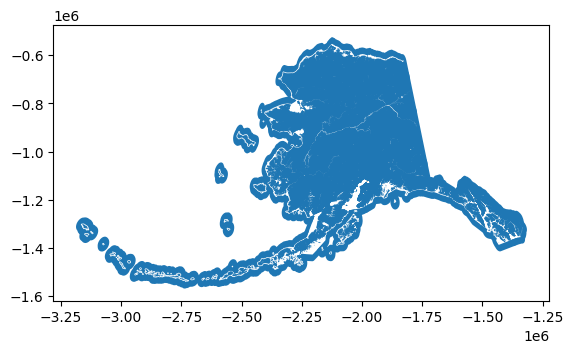

In [50]:
pygris.utils.shift_geometry(ak_tracts).plot()

In [36]:
pygris.utils.erase_water(ak_tracts, area_threshold=.50)

GEOSException: TopologyException: found non-noded intersection between LINESTRING (-135.016 58.121, -135.014 58.1207) and LINESTRING (-135.014 58.1207, -135.016 58.1211) at -135.01529656376565 58.120935179689468

In [51]:
gdf = tract_crosswalk.get_all_tract_geoms_year(year=2020, erase_water=True, simplify_tolerance=500, buffer_size=.5)

TypeError: get_all_tract_geoms_year() got an unexpected keyword argument 'buffer_size'

In [15]:
import pygeos as pg 

ak_tracts['geometry'] = pg.set_precision(ak_tracts.geometry.values.data, 1e-6)


/var/folders/qy/qp1k23kj0jj0bpkn10sx9mhh0000gn/T/ipykernel_37059/1587294109.py:3: DeprecationWarning: Accessing the underlying geometries through the `.data` attribute is deprecated and will be removed in GeoPandas 1.0. You can use `np.asarray(..)` or the `to_numpy()` method instead.
Note that if you are using PyGEOS and using this attribute to get an array of PyGEOS geometries, those other methods will always return an array of Shapely geometries. Accessing the underlying PyGEOS geometries directly is deprecated, and you should migrate to use Shapely >= 2.0 instead.
  ak_tracts['geometry'] = pg.set_precision(ak_tracts.geometry.values.data, 1e-6)


TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

In [26]:
ak_tracts['geometry'] = pg.set_precision(ak_tracts['geometry'], 1e-6)


TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

In [32]:
# Assuming ak_tracts is your GeoDataFrame

# # Convert all geometries to MultiPolygon
ak_tracts['geometry'] = ak_tracts['geometry'].apply(lambda geom: shapely.MultiPolygon([geom]) if isinstance(geom, shapely.Polygon) else geom)
ak_tracts['geometry'] = ak_tracts['geometry'].apply(lambda geom: pg.set_precision(geom, 1e-6) if geom else geom)


# # If you're using GeoPandas, you might want to explicitly set the geometry type
# ak_tracts = gpd.GeoDataFrame(ak_tracts, geometry='geometry')

TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

In [33]:
ak_tracts['geometry'] = ak_tracts['geometry'].apply(pg.set_precision, precision=1e-6)

TypeError: set_precision() missing 1 required positional argument: 'grid_size'

In [9]:
import pygris.utils

pygris.utils.erase_water(ak_tracts)

GEOSException: TopologyException: found non-noded intersection between LINESTRING (-135.016 58.121, -135.014 58.1207) and LINESTRING (-135.014 58.1207, -135.016 58.1211) at -135.01529656376565 58.120935179689468

In [ ]:
import geopandas as gpd
from shapely.geometry import MultiPolygon

def erase_water(geometries):
    # Buffer the geometries to address precision issues
    buffered_geometries = geometries.buffer(0)
    
    # Validate the geometries
    if not buffered_geometries.is_valid:
        # If not valid, try to fix the geometry
        buffered_geometries = buffered_geometries.buffer(0)
    
    # Perform the erase operation (replace 'water_geometry' with the actual water geometry)
    result = buffered_geometries.difference(water_geometry)
    
    return result


In [15]:
gdf = gpd.read_file('data/B19013_001E_DE-NJ+DC_2010-2020.json')

gdf.isna().sum()

GEOID          0
state_fips     0
state_name     0
state_usps     0
county_fips    0
county_name    0
tract_fips     0
tract_dec      0
B19013_001E    0
geometry       0
dtype: int64